In [382]:
#coding:utf-8
'''
HSI彩色图像空间分割
https://blog.csdn.net/liyuqian199695/article/details/70050981
'''
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pyexcel_xls import get_data

In [383]:
src = cv2.cvtColor(cv2.imread('datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [384]:
def rgb2hsi(src):
    rgb = np.float64(src)
    r = rgb[:,:,0] / 255
    g = rgb[:,:,1] / 255
    b = rgb[:,:,2] / 255
    
    hsi = np.zeros_like(rgb)
    eps = 1.0e-5
    num = 0.5 * ((r - g) + (r - b))
    den = np.sqrt((r - g) ** 2 + (r - b) * (g - b))
    theta = np.arccos(num / (den + eps)) # 防止除数为零
    
    H = theta
    H[b > g] = 2 * np.pi - H[b > g]
    H = H / (2 * np.pi)
    num = cv2.min(cv2.min(r,g),b)

    den = r + g + b
    den[den == 0] = eps
    S = 1 - 3.0 * num / den
    H[S == 0] = 0
    I = (r + g + b) / 3
    hsi[:,:,0] = H * 255
    hsi[:,:,1] = S * 255
    hsi[:,:,2] = I * 255
    return hsi

In [385]:
hsi = rgb2hsi(src)

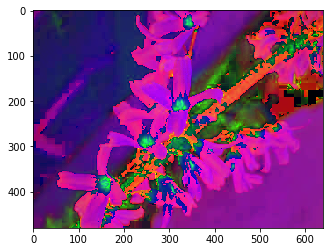

In [386]:
plt.imshow(cv2.convertScaleAbs(hsi))

In [387]:
import math
def pix_hsi2rgb(h,s,i):
    h = h*2*math.pi/255
    s = s/255
    i = i/255
    if h < 2*math.pi/3:
        r = min(1,i*(1+s*np.cos(h)/np.cos(math.pi/3-h)))
        b = i*(1-s)
        g = min(1,3*i-(r+b))
    else:
        if h < 4*math.pi/3:
            g = min(1,i*(1+s*np.cos(h - 2*math.pi/3)/np.cos(math.pi-h)))
            r = i*(1-s)
            b = min(1,3*i-(r+g))
        else:
            b = min(1,i*(1+s*np.cos(h-4*math.pi/3)/np.cos(5*math.pi/3-h)))
            g = i*(1-s)
            r = min(1,3*i-(g+b))
    r = int(round(r*255))
    g = int(round(g*255))
    b = int(round(b*255))
    return [r,g,b]
    

def hsi2rgb(src):
    hsi = np.float32(src)
    dst = np.zeros_like(hsi)
    rows,cols = src.shape[0],src.shape[1]
    for i in range(rows):
        for j in range(cols):
            rgb = hsi[i,j]
            dst[i,j] = pix_hsi2rgb(rgb[0],rgb[1],rgb[2])
    return dst
import pandas as pd
from pandas import DataFrame

def hsi2rgb_2(src):
    hsi = np.float32(src) / 255.0
    H = hsi[:,:,0] * 2 * np.pi
    S = hsi[:,:,1]
    I = hsi[:,:,2]
    
    df_H = DataFrame(H)
    
    R = np.zeros_like(H)
    G = np.zeros_like(H)
    B = np.zeros_like(H)
    
    # RG扇形(0 <= H < 2*pi/3)
    idx = (df_H >= 0.0) & (df_H < 2 * np.pi / 3)
    print(type(idx))
    B[idx] = I[idx] * (1 - S[idx]);
    R[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx]) / np.cos(np.pi/3 - H[idx]));
    G[idx] = 3*I[idx] - (R[idx] + B[idx]);
    
    # BG扇形(2*pi/3 <= H < 4*pi/3)
    idx = (df_H >= 2 * np.pi / 3) & (df_H < 4 * np.pi / 3)
    R[idx] = I[idx] * (1 - S[idx])
    G[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx] - 2*np.pi/3) / np.cos(np.pi - H[idx]))
    B[idx] = 3*I[idx] - (R[idx] + G[idx])
    
    # BR扇形
    idx = (df_H >= 4 * np.pi / 3) & (df_H <= 2 * np.pi)
    G[idx] = I[idx] * (1 - S[idx])
    B[idx] = I[idx] * (1 + S[idx] * np.cos(H[idx] - 4*np.pi/3) / np.cos(5*np.pi/3 - H[idx]))
    R[idx] = 3*I[idx] - (G[idx] + B[idx])
    
    dst = np.zeros_like(hsi)
   
    dst[:,:,0] = R * 255
    dst[:,:,1] = G * 255
    dst[:,:,2] = B * 255
    return cv2.convertScaleAbs(dst)

In [388]:
# dst = hsi2rgb(hsi)
dst = hsi2rgb_2(hsi)
print(dst.dtype)

<class 'pandas.core.frame.DataFrame'>
uint8


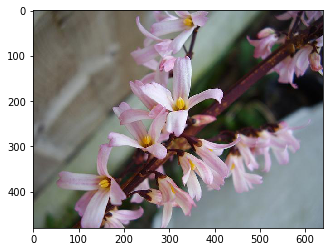

In [389]:
plt.imshow(dst)

In [390]:
channels = cv2.split(hsi)
H = channels[0]
S = channels[1]
I = channels[2]

<class 'pandas.core.frame.DataFrame'>


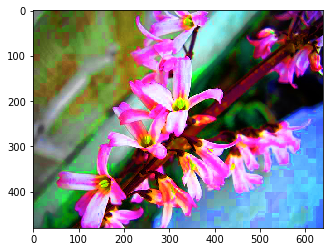

In [394]:

H_eq = cv2.equalizeHist(cv2.convertScaleAbs(H))
S_eq = cv2.equalizeHist(cv2.convertScaleAbs(S))
I_eq = cv2.equalizeHist(cv2.convertScaleAbs(I))

hsi_eq = cv2.merge([H_eq,S_eq,I_eq])
dst = hsi2rgb_2(hsi_eq)
plt.imshow(dst)